# SHAPE Detector for Endocytosis

This notebook demonstrates the detection stage of the [SHAPE](https://shape.utia.cas.cz) pipeline for Endocytosis.

You can train your own detector here and later use it with the <a href="https://colab.research.google.com/drive/1ZEcXHPD8jswWUxI6Wy9iFX0d5ikju1jv?usp=sharing" target="_blank">Endocytosis Colab.</a>

In [ ]:
#@title 🛠️ Install Dependencies
%autosave 300
import os, sys, requests, zipfile, subprocess

# Download SSL certificate
chain_path = '/content/chain-harica-cross.pem'
r = requests.get(
    'https://pki.cesnet.cz/_media/certs/chain-harica-rsa-ov-crosssigned-root.pem',
    timeout=10, stream=True
)
r.raise_for_status()
with open(chain_path, 'wb') as f:
    f.write(r.content)

zip_url = "https://shape.utia.cas.cz/files/detector/shape_det_0.2_107.zip"
extract_directory = "/content/shape"

def download_and_unzip(url, extract_to, chain_path):
    if os.path.exists(extract_to):
        print(f"The directory '{extract_to}' already exists. Skipping download and extraction.")
        return
    local_zip_file = url.split('/')[-1]
    with requests.get(url, stream=True, verify=chain_path) as r, open(local_zip_file,'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)
    os.makedirs(extract_to, exist_ok=True)
    with zipfile.ZipFile(local_zip_file,'r') as z:
        z.extractall(extract_to)
    os.remove(local_zip_file)
    print(f"Downloaded and extracted to '{extract_to}'.")

def install_packages(packages):
    for package in packages:
        try:
            __import__(package)
            print(f"'{package}' is already installed. Skipping.")
        except ImportError:
            print(f"Installing '{package}'...")
            subprocess.check_call([sys.executable,'-m','pip','install',package])
            print(f"'{package}' installed successfully.")

download_and_unzip(zip_url, extract_directory, chain_path)
os.chdir(extract_directory)
module_path = os.path.abspath('src')
if module_path not in sys.path:
    sys.path.append(module_path)

# required_packages = ["ortools","czifile","mrcfile","nd2","ipywidgets"]
# install_packages(required_packages)
print('✅ You are all set!')


Autosaving every 300 seconds
Downloaded and extracted to '/content/shape'.
✅ You are all set!


In [ ]:
#@title ⚙️ Training Parameters
import ipywidgets as widgets
from IPython.display import display

# Common style to make description wider
style = {'description_width': '120px'}  # Adjust width as needed

cycles_widget = widgets.IntText(
    value=20,
    description='Cycles:',
    style=style
)
batches_per_cycle_widget = widgets.IntText(
    value=100,
    description='Batches per cycle:',
    style=style
)
batch_size_widget = widgets.IntText(
    value=16,
    description='Batch size:',
    style=style
)


display(
    widgets.VBox([
        cycles_widget,
        batches_per_cycle_widget,
        batch_size_widget,
    ])
)

⚠️ *When small number of cycles (<20), the detection after training will fail (due to RAM), why?*

In [ ]:
#@title 🔄 Training

from torch.utils.data import DataLoader
from unet import UNet
from synthetic_data import SyntheticCCPDataset
import itertools, torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

batch_size = batch_size_widget.value
cycles = cycles_widget.value
batches_per_cycle = batches_per_cycle_widget.value

dataset = SyntheticCCPDataset()
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=2, pin_memory=True)

model = UNet(depth=3, start_filters=16, up_mode='nearest').to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=batch_size * 1e-5, weight_decay=0.05)
criterion = torch.nn.BCEWithLogitsLoss().to(device)
loss_history = []

for cycle in range(cycles):
    running_loss = 0.0
    model.train()
    for X, y in itertools.islice(dataloader, batches_per_cycle):
        X = X.to(device)[:,None].float()
        y = y.to(device)[:,None].float()
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() / batch_size
    avg_loss = running_loss / batches_per_cycle
    loss_history.append(avg_loss)
    print(f"cycle {cycle+1}/{cycles} - loss: {avg_loss:.4f}")
print('Training done.')


Using device: cuda
cycle 1/2 - loss: 0.0388
cycle 2/2 - loss: 0.0314
Training done.


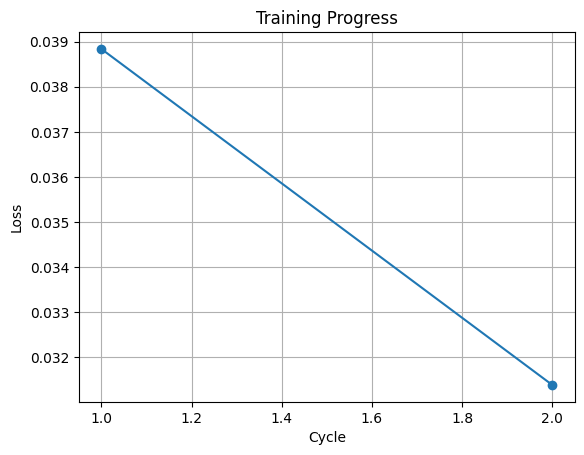

In [ ]:
#@title 📈 Plot Training Loss

import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(1, len(loss_history)+1), loss_history, marker='o')
plt.xlabel('Cycle')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.grid(True)
plt.show()


Now select a reconstruction file for endocytosis for detection.

In [ ]:
#@title 🖼️ Load Reconstruction TIFF (Exocytosis) for Testing (GDrive or Test Data)

import os, sys
from IPython.display import display, clear_output
import ipywidgets as widgets
from ipyfilechooser import FileChooser
import tifffile as tiff

movie = None
if 'google.colab' in sys.modules:
    from google.colab import drive

drive_mounted = os.path.exists('/content/drive/MyDrive')

# Source selector
source = widgets.RadioButtons(
    options=["Google Drive", "Test Data"],
    value="Google Drive",
    description="Source:"
)

# Mount button
mount_btn = widgets.Button(description="Mount Drive", button_style='info')
mount_btn.layout.display = None if (source.value=="Google Drive" and not drive_mounted) else 'none'

# File chooser
drive_chooser = FileChooser(
    '/content/drive/MyDrive' if drive_mounted else '/',
    title="Select TIFF",
    show_hidden=False
)
drive_chooser.filter_pattern = ['*.tif', '*.tiff']
drive_chooser.layout.display = None if (source.value=="Google Drive" and drive_mounted) else 'none'

# Load buttons
load_drive_btn = widgets.Button(description="Load from Drive", button_style='success')
load_drive_btn.layout.display = None if (source.value=="Google Drive" and drive_mounted) else 'none'

load_test_btn = widgets.Button(description="Load Test TIFF", button_style='success')
load_test_btn.layout.display = None if source.value=="Test Data" else 'none'

status = widgets.Output()

def refresh_ui():
    sel = source.value
    mount_btn.layout.display     = None if (sel=="Google Drive" and not drive_mounted) else 'none'
    drive_chooser.layout.display = None if (sel=="Google Drive" and drive_mounted) else 'none'
    load_drive_btn.layout.display= None if (sel=="Google Drive" and drive_mounted) else 'none'
    load_test_btn.layout.display = None if sel=="Test Data" else 'none'

def on_source_change(_):
    status.clear_output()
    refresh_ui()

def on_mount(_):
    global drive_mounted
    if drive_mounted: return
    status.clear_output()
    with status: print("🔄 Mounting Google Drive…")
    drive.mount('/content/drive')
    drive_mounted = True
    with status: print("✅ Mounted.")
    drive_chooser.root_dir = '/content/drive/MyDrive'
    drive_chooser.home_dir = '/content/drive/MyDrive'
    drive_chooser.reset()
    refresh_ui()

def load_from_drive(_):
    status.clear_output()
    fp = drive_chooser.selected
    if not fp or not os.path.isfile(fp):
        with status: print("❌ Select a valid .tif/.tiff")
        return
    with status: print(f"📥 Loading {fp}")
    global movie; movie = tiff.imread(fp)
    with status: print("✅ Loaded.", movie.shape)

def load_test(_):
    status.clear_output()
    fp = '/content/shape/data/Oxford/20240703/SHSY5Y_RUSHLAMP_CLCSNAP_107_reconstruction.tif'
    if not os.path.isfile(fp):
        with status: print(f"❌ Test file missing at {fp}")
        return
    with status: print(f"📥 Loading {fp}")
    global movie; movie = tiff.imread(fp)
    with status: print("✅ Loaded.", movie.shape)

source.observe(on_source_change, names='value')
mount_btn.on_click(on_mount)
load_drive_btn.on_click(load_from_drive)
load_test_btn.on_click(load_test)

display(source)
display(mount_btn)
display(drive_chooser)
display(load_drive_btn)
display(load_test_btn)
display(status)

refresh_ui()


RadioButtons(description='Source:', options=('Google Drive', 'Test Data'), value='Google Drive')

Button(button_style='info', description='Mount Drive', layout=Layout(display='none'), style=ButtonStyle())

FileChooser(path='/content/drive/MyDrive', filename='', title='Select TIFF', show_hidden=False, select_desc='S…

Button(button_style='success', description='Load from Drive', style=ButtonStyle())

Button(button_style='success', description='Load Test TIFF', layout=Layout(display='none'), style=ButtonStyle(…

Output()

In [ ]:
#@title 🔍 Run Detection

from detection import generate_ccp_detections
import torch

if movie is None:
    print('⚠️ No TIFF loaded. Please load a movie above.')
else:
    model.eval()
    detections = generate_ccp_detections(model, device, movie)
    print('✅ Detection finished!')


CCP detection:   0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
#@title ↳ Show Detection Positions
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation

if movie is None:
    print('No movie loaded.')
else:
    fig, ax = plt.subplots()
    im = ax.imshow(movie[0], cmap='gray')
    d0 = detections[detections.frame == 0]
    scat = ax.scatter(d0.x, d0.y, s=5, marker='+', c='red')
    def animate(i):
        im.set_array(movie[i])
        di = detections[detections.frame == i]
        scat.set_offsets(di[['x','y']].values if len(di) else [])
        return [im, scat]
    ani = animation.FuncAnimation(fig, animate, frames=movie.shape[0], interval=100, blit=True)
    plt.close(fig)
    display(HTML(ani.to_jshtml()))


In [ ]:
#@title Save the model ⚠️